In [7]:
import string

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # noqa
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters.utils import ROOT_DIR


In [8]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"

# Register dask progress bar
ProgressBar(minimum=5).register()


In [9]:
# Load and combine all test and train predictions
zarr_store = (
    ROOT_DIR / "models/predictions/global/ensemble_alltrain_10folds_combined.zarr"
)
ds = xr.open_zarr(zarr_store)
pred = ds.pred_ensemble_alltrain_nogap_lnll_latest.rename("twsa_ours")
sigma = ds.sigma_ensemble_alltrain_nogap_lnll_latest.rename("twsa_ours")


## Uncertainty map plot

In [10]:
# Compute mean uncertainty over time (1940-12 - 2021-12)
sigma_mean = sigma.mean("time").compute()


In [11]:
# Colorbar position: right
plot_kwargs = dict(
    rasterized=True,
    cbar_kwargs=dict(location="right", aspect=15, shrink=0.93, pad=0.03),
)


Plot TWSA and corresponding uncertainty

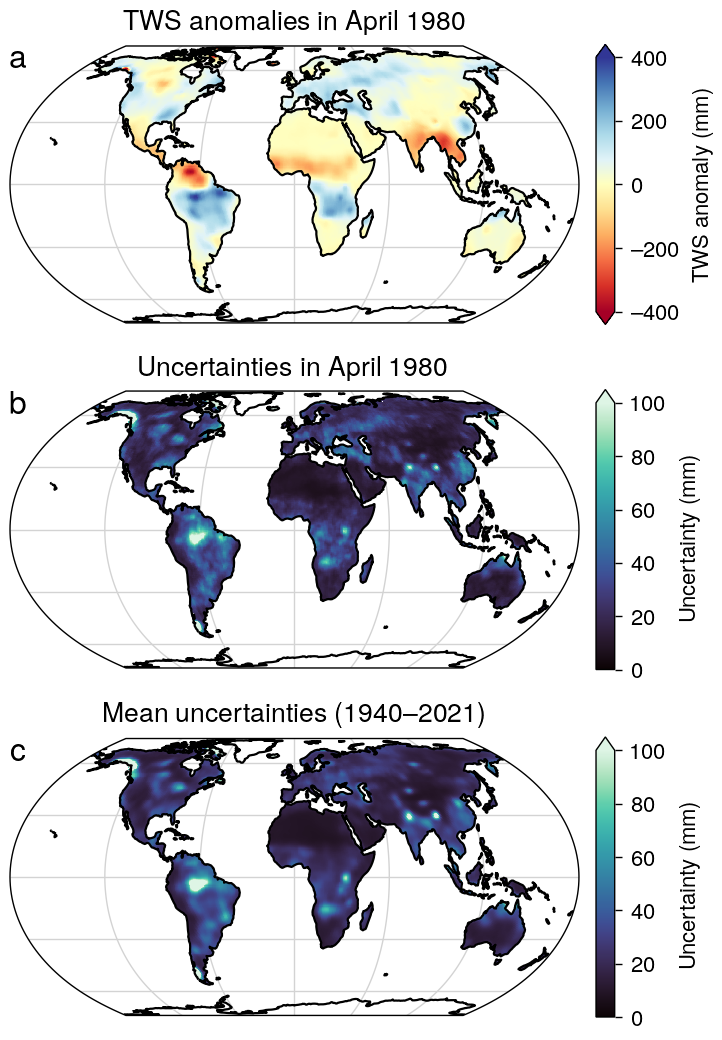

In [12]:
fig, axs = plt.subplots(
    nrows=3, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(3.6, 5.2)
)

PLOT_TIME = "1980-04"

plot_ts = pd.Timestamp(PLOT_TIME)
plot_year = plot_ts.year
plot_month = plot_ts.month_name()

# Add gridlines behind plot (default is on top)
for ax in axs:
    ax.gridlines(zorder=1)

# Plot 1 (TWSA of example month)
plot_kwargs["cbar_kwargs"]["label"] = "TWS anomaly (mm)"
pred.sel(time=PLOT_TIME).dw.projplot(
    vmin=-400,
    vmax=400,
    cmap="RdYlBu",
    ax=axs[0],
    zorder=2,
    **plot_kwargs,
)
axs[0].set(title=f"TWS anomalies in {plot_month} {plot_year}")

# Plot 2 (Uncertainty of example month)
plot_kwargs["cbar_kwargs"]["label"] = "Uncertainty (mm)"
sigma.sel(time=PLOT_TIME).dw.projplot(
    vmin=0,
    vmax=100,
    cmap="mako",
    ax=axs[1],
    zorder=2,
    **plot_kwargs,
)
axs[1].set(title=f"Uncertainties in {plot_month} {plot_year}")

# Plot 2 (Mean uncertainty over time)
sigma_mean.dw.projplot(
    vmin=0,
    vmax=100,
    cmap="mako",
    ax=axs[2],
    zorder=2,
    **plot_kwargs,
)
axs[2].set(title="Mean uncertainties (1940--2021)")

# Add coastlines
for ax in axs:
    ax.coastlines(rasterized=True, zorder=3)

# Add letters
for n, ax in enumerate(axs):
    ax.text(
        0.0,
        1.0 - 0.08,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "uncertainty_example.pdf", backend="pgf")
